In [222]:
# Define HOG Feature Extraction Function #
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False,block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec,block_norm='L2-Hys')
    return features
print ('#')

#


In [223]:
##Use Training Images

In [224]:
# Read in our vehicles and non-vehicles
car_images = glob.glob('training_data/vehicles/**/*.png', recursive=True)
notcar_images=glob.glob('training_data/non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in car_images:
        cars.append(image)
for image in notcar_images:
        notcars.append(image)

print (len(cars))
print (len(notcars))



8792
8968


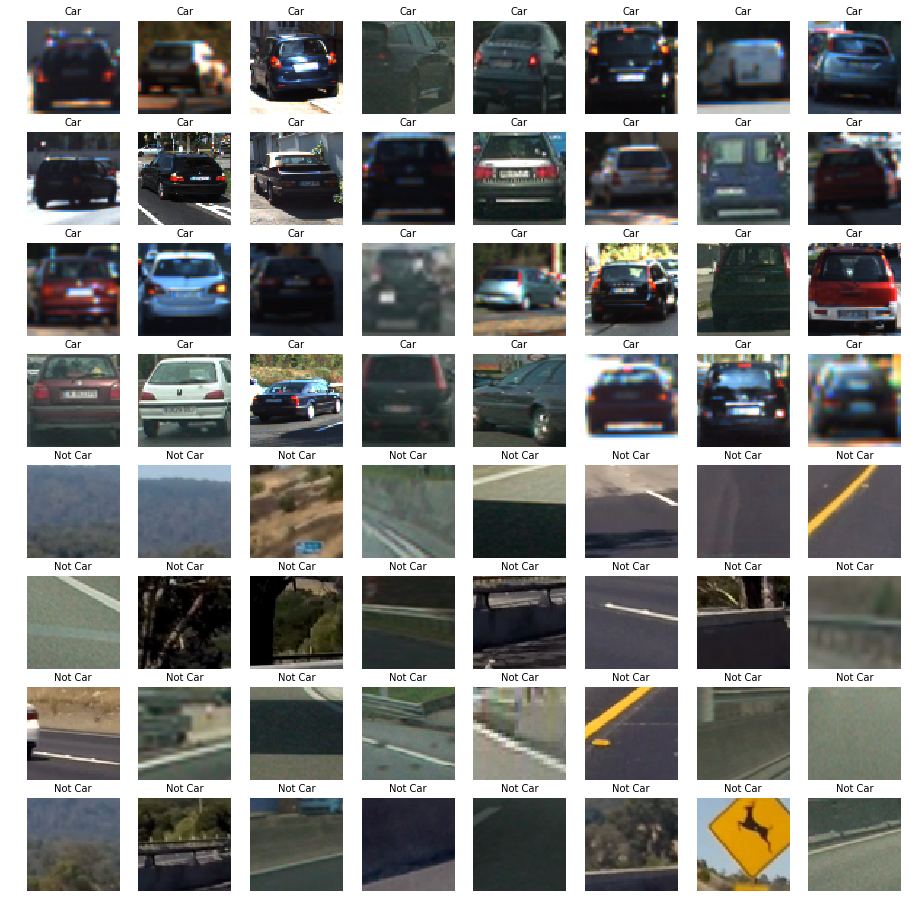

In [225]:
####See Some Imported Dataset###

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not Car', fontsize=10)
    axs[i].imshow(img)

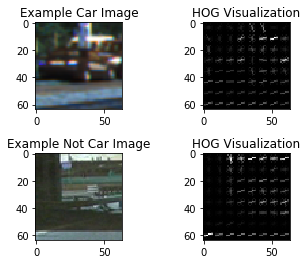

In [226]:
# Generate a random index to look at a car image
carind = np.random.randint(0, len(cars))
notcarind = np.random.randint(0, len(notcars))
# Read in the image
carimage = cv2.imread(cars[carind])
cargray = cv2.cvtColor(carimage, cv2.COLOR_BGR2GRAY)
notcarimage = cv2.imread(notcars[notcarind])
notcargray = cv2.cvtColor(notcarimage, cv2.COLOR_BGR2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(cargray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


features, hog_image2 = get_hog_features(notcargray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
fig.subplots_adjust(hspace = .5, wspace=.001)
plt.subplot(221)
plt.imshow(carimage, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(223)
plt.imshow(notcarimage, cmap='gray')
plt.title('Example Not Car Image')
plt.subplot(224)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

In [227]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
#     print ('Spatial Feature Shape:')
#     print (features.shape)
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
#     print ('Hist Feature Shape:')
#     print (hist_features.shape)
    return hist_features

# Method to Extract HOG Features on Image Set

In [228]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #print (image.shape)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features,spatial_features, hist_features)))
    # Return list of feature vectors
    return features
print('#')




#


# Test the Extract Features on a Set

In [326]:

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=(spatial,spatial),hist_bins=histbin)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=(spatial,spatial),hist_bins=histbin)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

136.76 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
19.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9752
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
0.00308 Seconds to predict 10 labels with SVC


| HOG Extraction      	|            	|              	|                 	|                 	|             	|              	| SVC Training 	|                      	|
|---------------------	|------------	|--------------	|-----------------	|-----------------	|-------------	|--------------	|--------------	|----------------------	|
| Configuration Label 	| Colorspace 	| Orientations 	| Pixels Per Cell 	| Cells Per Block 	| HOG Channel 	| Extract Time 	| SVC Training 	| Test Accuracy of SVC 	|
| 1                   	| YCrCb      	| 9            	| 8               	| 2               	| ALL         	| 11.46        	| 1.49         	| 0.945                	|
| 2                   	| RGB        	| 9            	| 8               	| 2               	| ALL         	| 8.18         	| 4.53         	| 0.92                 	|
| 3                   	| YCrCb      	| 9            	| 16              	| 2               	| ALL         	| 3.89         	| 0.5          	| 0.94                 	|
| 4                   	| HSV        	| 9            	| 8               	| 2               	| ALL         	| 9.03         	| 0.4          	| 0.955                	|
| 5                   	| HLS        	| 9            	| 8               	| 2               	| ALL         	| 9.56         	| 1.1          	| 0.955                	|
| 6                   	| HLS        	| 11           	| 8               	| 2               	| ALL         	| 9.59         	| 1.29         	| 0.96                 	|
| 7                   	| YUV        	| 11           	| 8               	| 2               	| ALL         	| 9.12         	| 1.44         	| 0.95                 	|
| 8                   	| HLS        	| 11           	| 16              	| 2               	| ALL         	| 4.14         	| 0.59         	| 0.97                 	|

# Method for Using Classifier to Detect Cars in an Image

Also Added Spatial Bin and Histogram Classification for SVC Prediction

In [327]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    img_features = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #img_features.append(hog_features)
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #img_features.append(spatial_features)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #img_features.append(hist_features)
            join_features = np.hstack((hog_features, spatial_features, hist_features))
            #join_features = np.concatenate(img_features)
#             print(hog_features.shape)
#             print(spatial_features.shape)
#             print(hist_features.shape)
#             print(join_features.shape)
            # Scale features and make a prediction
            test_features = X_scaler.transform((join_features).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            ######################################################################
            
#             test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('#')

#


# Test Detection on Example Image

In [328]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin)

print(len(rectangles), 'rectangles found in image')



3 rectangles found in image


# Method to Draw Rectangles onto an Image


In [329]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('#')

#


#


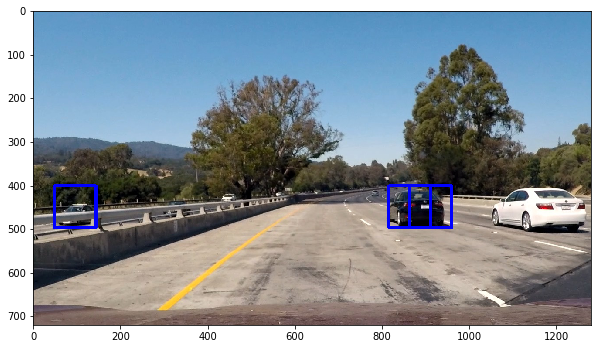

In [330]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('#')

# Search Areas and Relative Scales
 We will try scaling windows in different regions of image depending on distance from the camera.

Number of boxes:  78


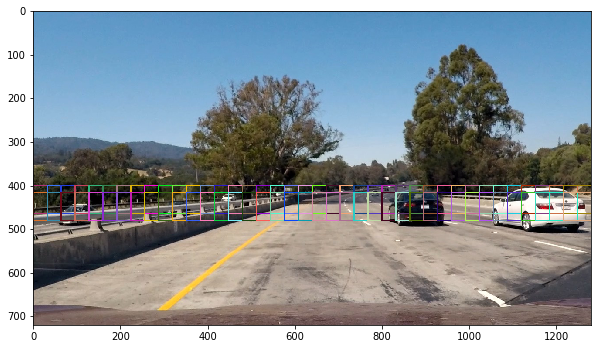

In [331]:
test_img = mpimg.imread('./test_images/test1.jpg')
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  50


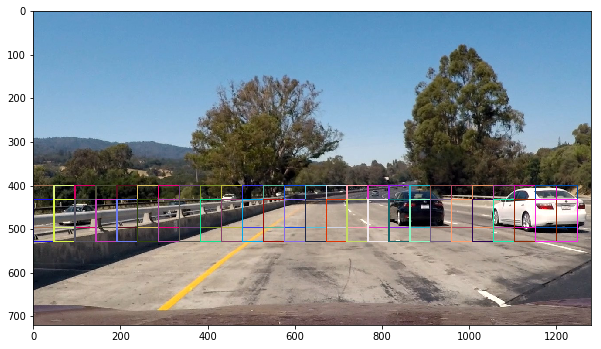

In [332]:
test_img = mpimg.imread('./test_images/test1.jpg')
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


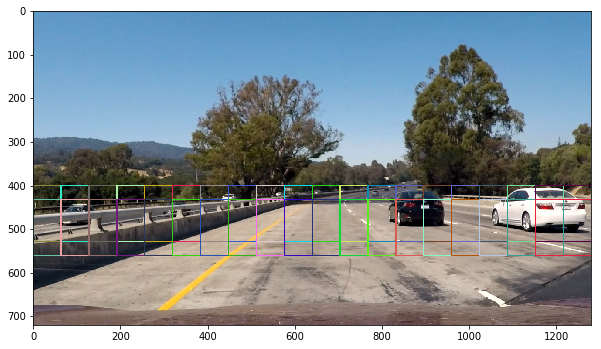

In [333]:
test_img = mpimg.imread('./test_images/test1.jpg')
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


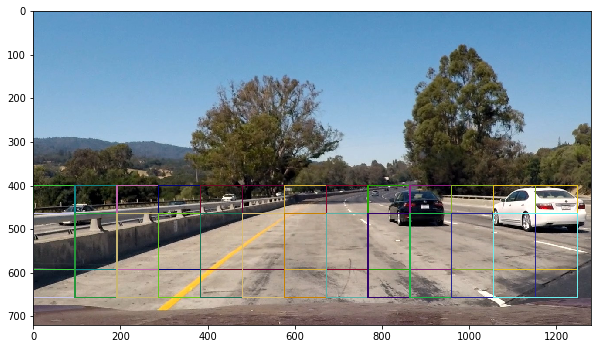

In [334]:
test_img = mpimg.imread('./test_images/test1.jpg')
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin,show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

# Combine All Searches

#


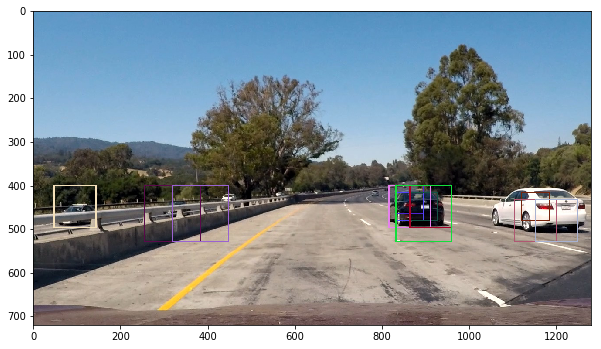

In [335]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))


ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))


ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))


ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))


ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))


ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))


ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))



# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('#')

# Heatmap

This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).


In [336]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('#')

#


#


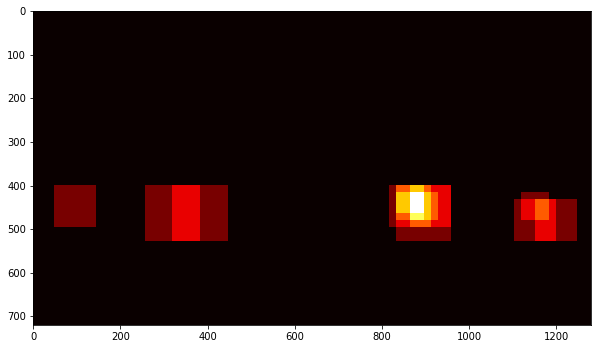

In [337]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('#')

# Heatmap Thresholding

In [338]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('#')

#


...


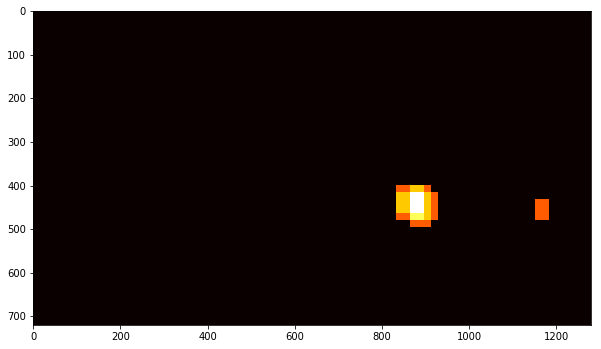

In [340]:
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

# Labels to Heatmap


2 cars found


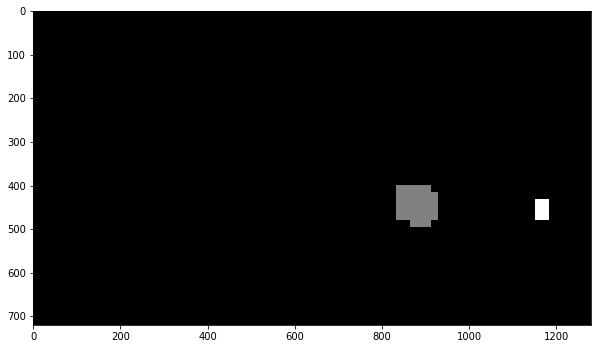

In [341]:
from scipy.ndimage.measurements import label

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

# Draw Bounding Boxes for Lables


#


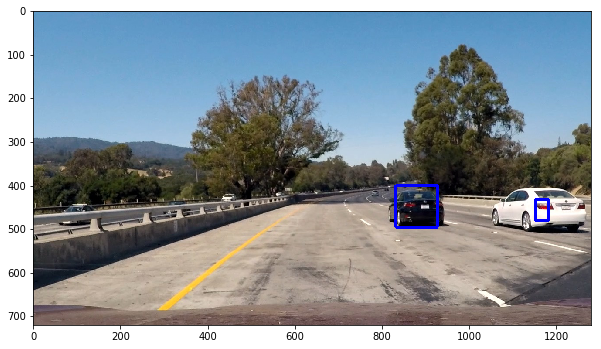

In [342]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('#')

# Process Image Pipeline

In [343]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('#')

#


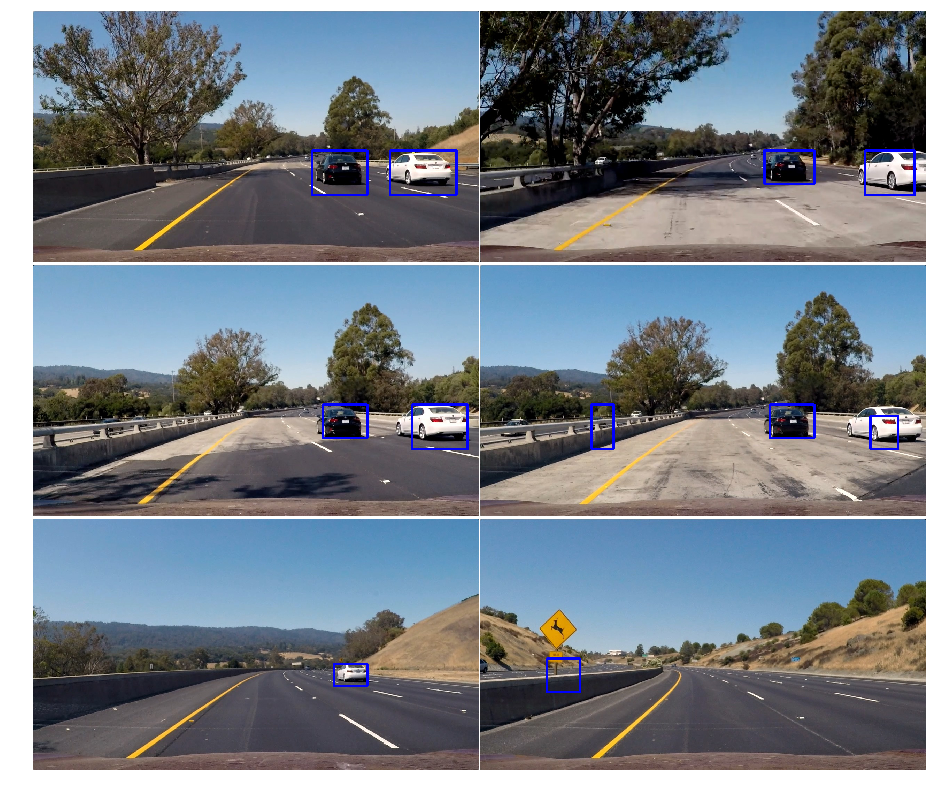

In [344]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

# Test Pipeline on Video

In [345]:
from moviepy.editor import VideoFileClip

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 19.9 s, sys: 1.5 s, total: 21.4 s
Wall time: 24.2 s


In [349]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('#')

#


In [350]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial,spatial), histbin))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('#')

#


In [351]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)
print('#')

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 19.2 s, sys: 1.34 s, total: 20.5 s
Wall time: 22.8 s
#
